# Necessary imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys

# Change this depending on where in the PSC folder you put the notebook

sys.path.append('../')


import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.linalg import qr
import scipy.stats as stats
import pandas as pd

from pymanopt.manifolds.stiefel import Stiefel

from PSC.utils import dist_Gr, projection_cost, nuc_cost
from PSC.projections import manopt_alpha, PCA, pi_alpha_all, yhat_alpha_all

# Functions

In [2]:
def phi_on_line(a, b, point):
    if point <=a or point >=b:
        return 0.0
    else:
        return (np.cos(np.pi*(point-(a+b)/2)/(b-a)))**2
    

def phi_on_circle(a, b):
    def inner_function(point):
        point = point % 1
        if b < a:
            if 0 <= point < b:
                point = point + 1
                return phi_on_line(a, 1+b, point)
            else:
                return phi_on_line(a, 1+b, point)
        else:
            return phi_on_line(a, b, point)
    return inner_function


def mobius_transition_function(k,l):
    if k <= l:
        return 1
    else:
        return -1
    

def normalized_phi_on_circle(a, b, list_of_unnormalized_phis):
    def inner_function(point):
        norm_factor = 0.0
        for phi_function in list_of_unnormalized_phis:
            value = phi_function(point)
            norm_factor = norm_factor + value
        return (phi_on_circle(a,b)(point))/norm_factor
    return inner_function


# Run trials

### Note: for completeness, we compute alpha_GD initialized from both alpha_PCA and a randomly selected alpha

In [3]:
list_mse_for_alpha_random = np.array([])
list_mse_for_alpha_pca = np.array([])
list_mse_for_alpha_gd_from_pca = np.array([])
list_mse_for_alpha_gd_from_random = np.array([])


list_grassmannian_projection_costs_for_alpha_random = np.array([])
list_grassmannian_projection_costs_for_alpha_pca = np.array([])
list_grassmannian_projection_costs_for_alpha_gd_from_pca = np.array([])
list_grassmannian_projection_costs_for_alpha_gd_from_random = np.array([])


num_trials = 20



In [4]:
for trial_index in range(num_trials):

    print(f'Working on trial {trial_index}...')


    # SAMPLE POINTS ON S^1 = V_1(R^2)
    # Define the range
    a, b = 0.0, 0.999999

    # Number of points
    num_points = 1000

    # Generate random points in the range (a, b)
    sampled_circle_points = a + (b - a) * np.random.rand(num_points)


    # SET HYPERPARAMETERS FOR RUN
    N = 25
    n = 2
    k = 1

    size_of_open_sets = 2/N

    step_size = 1/N
    # Define the start and end points
    start = 0.0
    end = 1 - step_size

    # Create the list of intervals
    list_of_open_sets = np.array([[i, (i + size_of_open_sets)%1] for i in np.arange(start, end + step_size, step_size)])
    list_of_open_sets


    list_of_phis_on_circle = []
    for open_set in list_of_open_sets:
        phi = phi_on_circle(open_set[0], open_set[1])
        list_of_phis_on_circle.append(phi)
    list_of_phis_on_circle = np.array(list_of_phis_on_circle)
    list_of_phis_on_circle






    # EMBED POINTS IN V_k(R^N)
    points_in_V_k_R_N = np.zeros((N, num_points))

    epsilon = 0.0

    for (circle_index, point) in enumerate(sampled_circle_points):
        print(f'Working on index {circle_index} out of {sampled_circle_points.shape[0]}')
        # Find a U_l that contains the point
        index_of_containing_open_set = -1
        found_open_set = False
        while found_open_set == False:
            index_of_containing_open_set = index_of_containing_open_set + 1
            if list_of_open_sets[index_of_containing_open_set][0] < list_of_open_sets[index_of_containing_open_set][1] and list_of_open_sets[index_of_containing_open_set][0] < point < list_of_open_sets[index_of_containing_open_set][1]:
                found_open_set = True
                print(index_of_containing_open_set)
            if list_of_open_sets[index_of_containing_open_set][0] > list_of_open_sets[index_of_containing_open_set][1] and list_of_open_sets[index_of_containing_open_set][0] < point < 1 + list_of_open_sets[index_of_containing_open_set][1]:
                found_open_set = True
                print(index_of_containing_open_set)
            if list_of_open_sets[index_of_containing_open_set][0] > list_of_open_sets[index_of_containing_open_set][1] and point < list_of_open_sets[index_of_containing_open_set][1]:
                found_open_set = True
                print(index_of_containing_open_set)

        vector = np.zeros((N))

        for row_index in range(N):
            open_set_a = list_of_open_sets[row_index][0]
            open_set_b = list_of_open_sets[row_index][1]
            sign = mobius_transition_function(row_index, index_of_containing_open_set)
            phi_function = normalized_phi_on_circle(open_set_a, open_set_b, list_of_phis_on_circle)
            value = sign*np.sqrt(phi_function(point))
            vector[row_index] = value


        
        points_in_V_k_R_N[:,circle_index] = vector



    # RESHAPE POINTS IN V_k(R^N)
    ys = np.zeros((num_points, N, k))
    for index in range(num_points):
        ys[index, :, 0] = points_in_V_k_R_N[:,index]






    # DO DIMENSIONALITY REUDCTION WITH VARIOUS ALPHA'S
    St_Nn = Stiefel(N, n)
    alpha_random = St_Nn.random_point() # for comparison
    alpha_PCA = PCA(ys, n)
    alpha_GD_from_PCA = manopt_alpha(ys, alpha_PCA)
    alpha_GD_from_random = manopt_alpha(ys, alpha_random)





    # GET L2 PROJECTION COSTS FOR EACH ALPHA
    # L2 projection costs for random
    random_l2_projection_costs = []
    random_grassmannian_projection_costs = []
    yhats = yhat_alpha_all(alpha_random, ys)

    for index in range(yhats.shape[0]):
        yhat = yhats[index, :, 0]
        alpha_random_yhat = alpha_random@yhat.T
        y = ys[index, :, 0]
        l2_distance = np.linalg.norm(y - alpha_random_yhat)
        random_l2_projection_costs.append(l2_distance)
        
        yhat = yhats[index, :, :]
        alpha_random_yhat = alpha_random@yhat
        y = ys[index, :, :]
        grassmannian_distance = dist_Gr(y, alpha_random_yhat)
        random_grassmannian_projection_costs.append(grassmannian_distance)


    # L2 projection costs for PCA
    pca_l2_projection_costs = []
    pca_grassmannian_projection_costs = []
    yhats = yhat_alpha_all(alpha_PCA, ys)

    for index in range(yhats.shape[0]):
        yhat = yhats[index, :, 0]
        alpha_PCA_yhat = alpha_PCA@yhat.T
        y = ys[index, :, 0]
        l2_distance = np.linalg.norm(y - alpha_PCA_yhat)
        pca_l2_projection_costs.append(l2_distance)

                
        yhat = yhats[index, :, :]
        alpha_PCA_yhat = alpha_PCA@yhat
        y = ys[index, :, :]
        grassmannain_distance = dist_Gr(y, alpha_PCA_yhat)
        pca_grassmannian_projection_costs.append(grassmannian_distance)


    # L2 projection costs for gradient descent from pca
    gd_from_pca_l2_projection_costs = []
    gd_from_pca_grassmannian_projection_costs = []
    yhats = yhat_alpha_all(alpha_GD_from_PCA, ys)

    for index in range(yhats.shape[0]):
        yhat = yhats[index, :, 0]
        alpha_GD_yhat = alpha_GD_from_PCA@yhat.T
        y = ys[index, :, 0]
        l2_distance = np.linalg.norm(y - alpha_GD_yhat)
        gd_from_pca_l2_projection_costs.append(l2_distance)

        yhat = yhats[index, :, :]
        alpha_GD_yhat = alpha_GD_from_PCA@yhat
        y = ys[index, :, :]
        grassmannian_distance = dist_Gr(y, alpha_GD_yhat)
        gd_from_pca_grassmannian_projection_costs.append(grassmannian_distance)



    # L2 projection costs for gradient descent from random
    gd_from_random_l2_projection_costs = []
    gd_from_random_grassmannian_projection_costs = []
    yhats = yhat_alpha_all(alpha_GD_from_random, ys)

    for index in range(yhats.shape[0]):
        yhat = yhats[index, :, 0]
        alpha_GD_yhat = alpha_GD_from_random@yhat.T
        y = ys[index, :, 0]
        l2_distance = np.linalg.norm(y - alpha_GD_yhat)
                
        yhat = yhats[index, :, :]
        alpha_GD_yhat = alpha_GD_from_random@yhat
        gd_from_random_l2_projection_costs.append(l2_distance)
        y = ys[index, :, :]
        grassmannian_distance = dist_Gr(y, alpha_GD_yhat)
        gd_from_random_grassmannian_projection_costs.append(grassmannian_distance)




    # FINAL COST CALCULATIONS
    mse_for_random = 0.0
    for distance in random_l2_projection_costs:
        mse_for_random = mse_for_random + (distance)**2
    mse_for_random = (1/num_points)*mse_for_random

    mse_for_pca = 0.0
    for distance in pca_l2_projection_costs:
        mse_for_pca = mse_for_pca + (distance)**2
    mse_for_pca = (1/num_points)*mse_for_pca

    mse_for_gd_from_pca = 0.0
    for distance in gd_from_pca_l2_projection_costs:
        mse_for_gd_from_pca = mse_for_gd_from_pca + (distance)**2
    mse_for_gd_from_pca = (1/num_points)*mse_for_gd_from_pca

    mse_for_gd_from_random = 0.0
    for distance in gd_from_random_l2_projection_costs:
        mse_for_gd_from_random = mse_for_gd_from_random + (distance)**2
    mse_for_gd_from_random = (1/num_points)*mse_for_gd_from_random


    list_mse_for_alpha_random = np.append(list_mse_for_alpha_random, mse_for_random)
    list_mse_for_alpha_pca = np.append(list_mse_for_alpha_pca, mse_for_pca)
    list_mse_for_alpha_gd_from_pca = np.append(list_mse_for_alpha_gd_from_pca, mse_for_gd_from_pca)
    list_mse_for_alpha_gd_from_random = np.append(list_mse_for_alpha_gd_from_random, mse_for_gd_from_random)


    # grassmannian_cost_for_random = 0.0
    # for distance in random_grassmannian_projection_costs:
    #     grassmannian_cost_for_random = grassmannian_cost_for_random + (distance)**2
    # grassmannian_cost_for_random = np.sqrt(grassmannian_cost_for_random)

    # grassmannian_cost_for_pca = 0.0
    # for distance in pca_grassmannian_projection_costs:
    #     grassmannian_cost_for_pca = grassmannian_cost_for_pca + (distance)**2
    # grassmannian_cost_for_pca = np.sqrt(grassmannian_cost_for_pca)

    # grassmannian_cost_for_gd_from_pca = 0.0
    # for distance in gd_from_pca_grassmannian_projection_costs:
    #     grassmannian_cost_for_gd_from_pca = grassmannian_cost_for_gd_from_pca + (distance)**2
    # grassmannian_cost_for_gd_from_pca = np.sqrt(grassmannian_cost_for_gd_from_pca)

    # grassmannian_cost_for_gd_from_random = 0.0
    # for distance in gd_from_random_grassmannian_projection_costs:
    #     grassmannian_cost_for_gd_from_random = grassmannian_cost_for_gd_from_random + (distance)**2
    # grassmannian_cost_for_gd_from_random = np.sqrt(grassmannian_cost_for_gd_from_random)


    # list_grassmannian_projection_costs_for_alpha_random = np.append(list_grassmannian_projection_costs_for_alpha_random, grassmannian_cost_for_random)
    # list_grassmannian_projection_costs_for_alpha_pca = np.append(list_grassmannian_projection_costs_for_alpha_pca, grassmannian_cost_for_pca)
    # list_grassmannian_projection_costs_for_alpha_gd_from_pca = np.append(list_grassmannian_projection_costs_for_alpha_gd_from_pca, grassmannian_cost_for_gd_from_pca)
    # list_grassmannian_projection_costs_for_alpha_gd_from_random = np.append(list_grassmannian_projection_costs_for_alpha_gd_from_random, grassmannian_cost_for_gd_from_random)




Working on trial 0...
Working on index 0 out of 1000
0
Working on index 1 out of 1000
14
Working on index 2 out of 1000
6
Working on index 3 out of 1000
23
Working on index 4 out of 1000
0
Working on index 5 out of 1000
8
Working on index 6 out of 1000
6
Working on index 7 out of 1000
17
Working on index 8 out of 1000
9
Working on index 9 out of 1000
12
Working on index 10 out of 1000
21
Working on index 11 out of 1000
15
Working on index 12 out of 1000
21
Working on index 13 out of 1000
9
Working on index 14 out of 1000
15
Working on index 15 out of 1000
7
Working on index 16 out of 1000
14
Working on index 17 out of 1000
19
Working on index 18 out of 1000
7
Working on index 19 out of 1000
4
Working on index 20 out of 1000
17
Working on index 21 out of 1000
20
Working on index 22 out of 1000
4
Working on index 23 out of 1000
7
Working on index 24 out of 1000
8
Working on index 25 out of 1000
14
Working on index 26 out of 1000
21
Working on index 27 out of 1000
5
Working on index 28 ou

# Analyze results

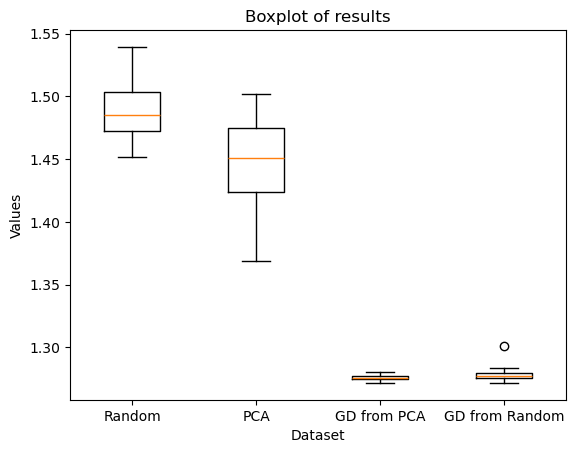

In [5]:
data1 = list_mse_for_alpha_random
data2 = list_mse_for_alpha_pca
data3 = list_mse_for_alpha_gd_from_pca
data4 = list_mse_for_alpha_gd_from_random

# Create a list of datasets
data = [data1, data2, data3, data4]

# Create a boxplot
plt.boxplot(data)

# Add a title and labels
plt.title('Boxplot of results')
plt.xlabel('Dataset')
plt.ylabel('Values')
plt.xticks([1, 2, 3, 4], ['Random', 'PCA', 'GD from PCA', 'GD from Random'])  # Custom x-axis labels

# Show the plot
plt.show()

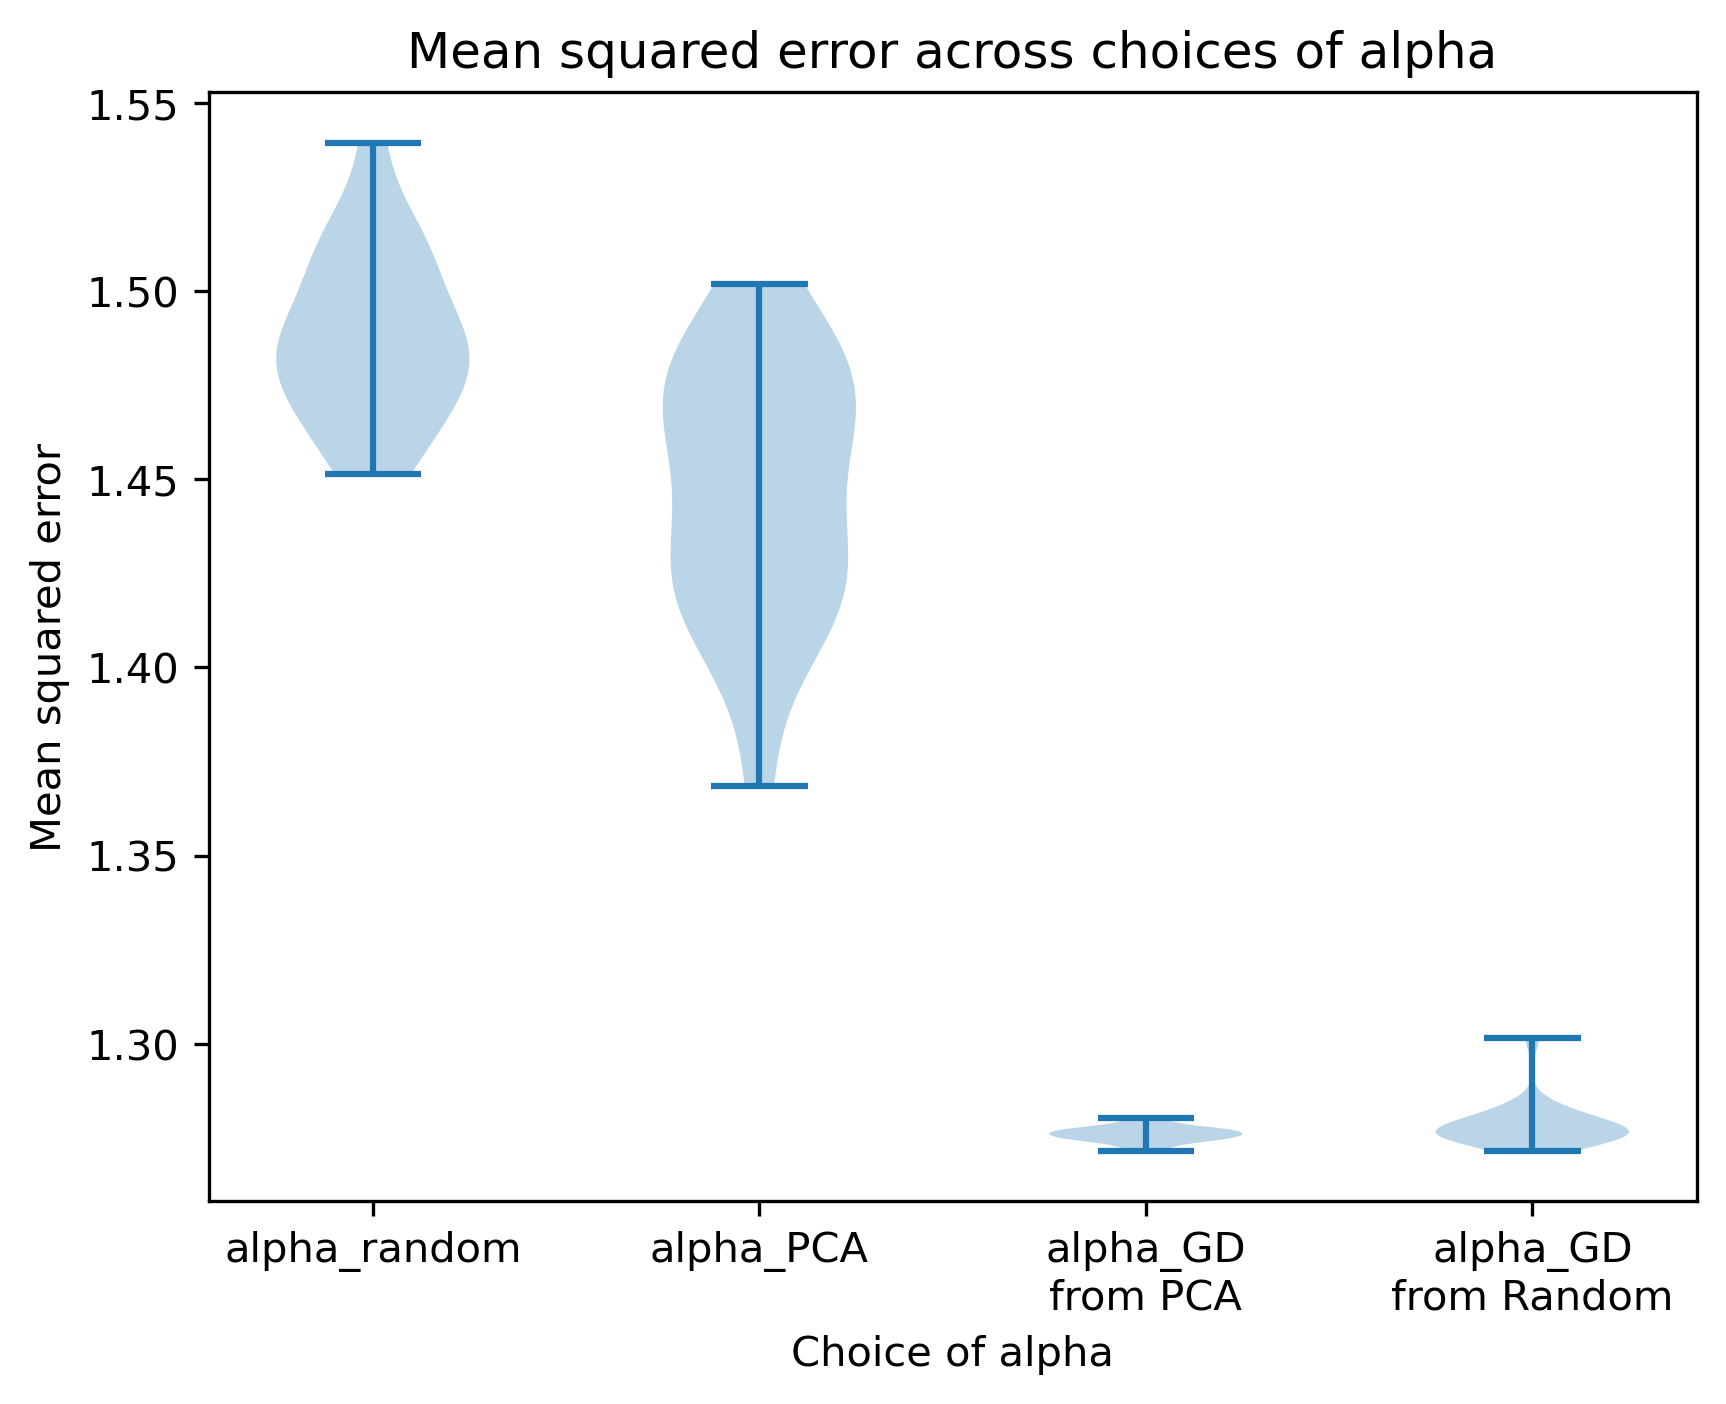

In [6]:
import matplotlib.pyplot as plt

plt.figure(dpi=300)

# Create a list of datasets
data = [data1, data2, data3, data4]

# Create a violin plot
plt.violinplot(data)

# Add a title and labels
plt.title('Mean squared error across choices of alpha')
plt.xlabel('Choice of alpha')
plt.ylabel('Mean squared error')
plt.xticks([1, 2, 3, 4], ['alpha_random', 'alpha_PCA', 'alpha_GD\nfrom PCA', 'alpha_GD\nfrom Random'])  # Custom x-axis labels

# Show the plot
plt.show()


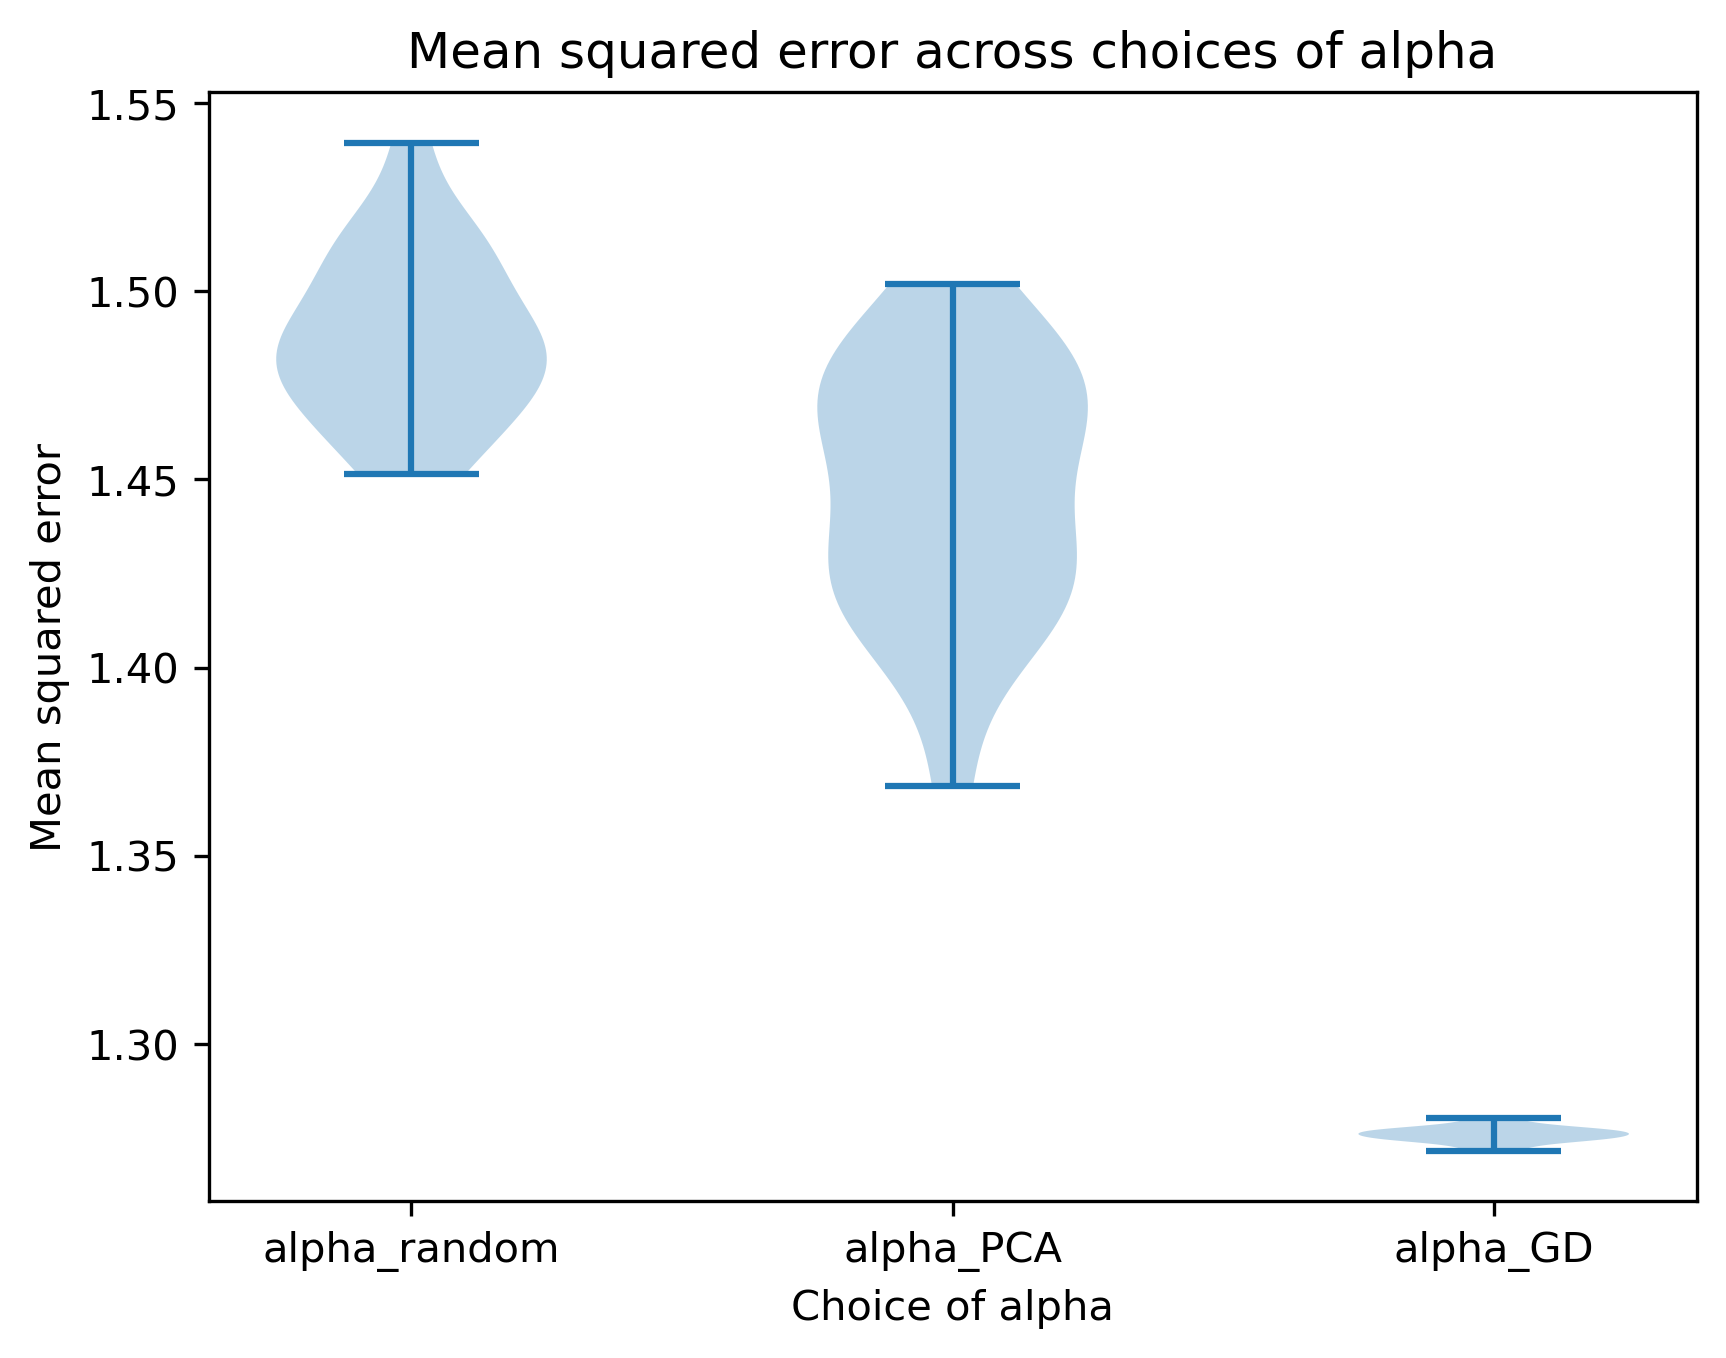

In [7]:
import matplotlib.pyplot as plt

plt.figure(dpi=300)

# Create a list of datasets
data = [data1, data2, data3]

# Create a violin plot
plt.violinplot(data)

# Add a title and labels
plt.title('Mean squared error across choices of alpha')
plt.xlabel('Choice of alpha')
plt.ylabel('Mean squared error')
plt.xticks([1, 2, 3], ['alpha_random', 'alpha_PCA', 'alpha_GD'])  # Custom x-axis labels


# Show the plot
plt.show()


In [8]:
# List of datasets
data = [data1, data2, data3, data4]
labels = ['Random', 'PCA', 'GD from PCA', 'GD from Random']

# Perform t-tests and store results
results = []
for i in range(len(data)):
    for j in range(i + 1, len(data)):
        t_stat, p_val = stats.ttest_ind(data[i], data[j])
        results.append({
            'Selected alpha 1': labels[i],
            'Selected alpha 2': labels[j],
            't-statistic': t_stat,
            'p-value': p_val
        })

# Create a DataFrame from the results
df_results = pd.DataFrame(results)

# Display the DataFrame
print(df_results)


  Selected alpha 1 Selected alpha 2  t-statistic       p-value
0           Random              PCA     4.473158  6.777801e-05
1           Random      GD from PCA    41.750037  2.325992e-33
2           Random   GD from Random    39.981641  1.162412e-32
3              PCA      GD from PCA    22.167032  2.448375e-23
4              PCA   GD from Random    21.544173  6.689968e-23
5      GD from PCA   GD from Random    -1.702568  9.681708e-02


In [9]:
import pandas as pd
import scipy.stats as stats

# List of datasets
data = [data1, data2, data3, data4]
labels = ['Random', 'PCA', 'GD from PCA', 'GD from Random']

# Perform t-tests and store results
results = []
for i in range(len(data)):
    for j in range(i + 1, len(data)):
        t_stat, p_val = stats.ttest_ind(data[i], data[j])
        results.append({
            'alpha 1': labels[i],
            'alpha 2': labels[j],
            'p-value': p_val
        })

# Create a DataFrame from the results
df_results = pd.DataFrame(results)

# Display the DataFrame with a horizontal line below the header
styled_df = df_results.style.set_table_styles(
    [{'selector': 'th', 'props': [('border-bottom', '2px solid black')]}]
).hide(axis='index').format({'p-value': '{:.2e}'})

# Display the styled DataFrame
styled_df


alpha 1,alpha 2,p-value
Random,PCA,6.78e-05
Random,GD from PCA,2.33e-33
Random,GD from Random,1.16e-32
PCA,GD from PCA,2.45e-23
PCA,GD from Random,6.69e-23
GD from PCA,GD from Random,9.68e-02


In [10]:
np.mean(data2)

1.4466805685466018

In [11]:
np.mean(data3)

1.2759446955274425

In [12]:
(np.mean(data2) - np.mean(data3))/np.mean(data2)

0.11801905460767192

In [13]:
data3

array([1.27720255, 1.2754227 , 1.27562588, 1.27163166, 1.27255259,
       1.27671704, 1.27417204, 1.27619104, 1.27439404, 1.27705999,
       1.27696477, 1.27758535, 1.27528493, 1.27903842, 1.2747948 ,
       1.27668392, 1.27536382, 1.28021898, 1.27433019, 1.2776592 ])

In [14]:
data4

array([1.27720255, 1.2754227 , 1.27562588, 1.27163166, 1.28104722,
       1.27671704, 1.27417204, 1.27619104, 1.27439404, 1.30141083,
       1.27696477, 1.27758535, 1.28342945, 1.27903842, 1.2747948 ,
       1.27668392, 1.27536382, 1.28021898, 1.28264434, 1.2776592 ])